## What is a State in LangGraph?

- **State = shared memory** that moves through your LangGraph workflow.
- It holds everything the nodes need to see or update (like a conversation or tool results).

### What’s inside a state?
- Typically a Python dictionary with fields like:
  - `messages`: the conversation history
  - `tool_results`: outputs from tools
  - `query`: user input
  - Anything else your app needs to remember

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## What are Nodes and Edges in LangGraph?

### Nodes
- **Nodes are the steps in your flow.**
- Each node does something: calls an LLM, looks up a database, filters results, etc.
- You can think of a node like a function or block in a flowchart.
- Example: A node might answer a question using an LLM.

### Edges
- **Edges connect the nodes and decide what happens next.**
- They define the **path** the data takes.
- Edges can be simple (go to the next step) or conditional (go here **if** something is true).
- Example: If the LLM says “I need more info,” the edge might loop back to a retriever node.

### Think of it like this:
- Nodes = **What to do**
- Edges = **Where to go next**

### Why it matters in LangGraph
- LangGraph lets you build **smart workflows** where LLMs can make decisions.
- You use nodes to define actions.
- You use edges to define logic (e.g., "if answer is good, stop", "if not, try again").

### Bonus analogy:
> It's like a choose-your-own-adventure book:
> - Each page is a **node** (an event or action),
> - The choices are **edges** (which page you flip to next).


In [4]:
import os
from langchain.chat_models import init_chat_model

OPENAI_API_KEY: str | None = os.getenv("OPENAI_API_KEY")

#os.environ["OPENAI_API_KEY"] = "sk-..."

llm = init_chat_model("openai:gpt-4.1")

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

In [7]:
graph = graph_builder.compile()

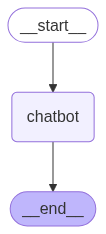

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

### Add a tool

In [12]:
TAVILY_API_KEY: str | None = os.getenv("TAVILY_API_KEY")

In [13]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges',
   'url': 'https://medium.com/@vivekvjnk/langgraph-basics-understanding-state-schema-nodes-and-edges-77f2fd17cae5',
   'content': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges | by Story_Teller | Medium LangGraph Basics: Understanding State, Schema, Nodes, and Edges LangGraph Basics: Understanding State, Schema, Nodes, and Edges These predefined structures in the messaging app are synonymous with the schema of the state in LangGraph. Just as a messaging app ensures all interactions (messages) follow a consistent format, the schema in LangGraph ensures the state passed along edges is structured and interpretable. This static schema allows nodes to rely on a consistent state format, ensuring seamless communication along edges throughout the graph. In this article, we explored t

In [18]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

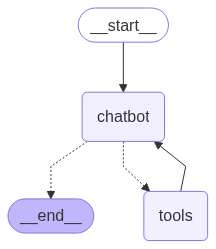

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  search about greek economy


Assistant: 
Assistant: {"query": "Greek economy overview 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://economy-finance.ec.europa.eu/economic-surveillance-eu-economies/greece/economic-forecast-greece_en", "title": "Economic forecast for Greece - Economy and Finance", "content": "The Greek economy posted a solid 2.1% y-o-y growth in the first half of 2024, driven primarily by domestic demand, while net exports were a drag on growth. Following minimum wage hikes, private consumption benefited from the relatively faster wage increase for lower-income households that tend to have a higher propensity to consume. Equipment investment accelerated in parallel with a strong pick-up in corporate credit growth, while a surge in imports accompanied by sluggish export growth [...] prompted a decline in net exports. Thanks to strong domestic demand, real GDP growth is expected to average 2.1% in 2024. [...] Economic activity is expected to expand by 2.

User:  end


Assistant: It looks like you've typed "end." If you'd like to finish the conversation or have a specific request, please let me know! If you need help with something else, just ask.
User: What do you know about LangGraph?
Assistant: 
Assistant: {"query": "LangGraph AI framework", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "langchain-ai/langgraph: Build resilient language agents as graphs. - GitHub", "url": "https://github.com/langchain-ai/langgraph", "content": "| Latest commit [jacoblee93](/jacoblee93)[jacoblee93](/langchain-ai/langgraph/commits?author=jacoblee93)  [docs: Adds additional Google Analytics tag to docs (](/langchain-ai/langgraph/commit/c7fe85585b430f62fa7f0780fc74bd9de982b2ad)[#4402](https://github.com/langchain-ai/langgraph/pull/4402)[)](/langchain-ai/langgraph/commit/c7fe85585b430f62fa7f0780fc74bd9de982b2ad) Apr 24, 2025  [c7fe855](/langchain-ai/langgraph/commit/c7fe85585b430f62fa7f0780fc74bd9de982b2ad) · Apr 24, 2025  History[5,09